# 6.864 Project
$\textbf{Main idea}$: Testing the limits of zero-shot and few-shot learning for labeling at scale.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%%bash
# Logistics #2: install the transformers package, create a folder, download the dataset and a patch
pip -q install transformers
pip -q install datasets
pip -q install tqdm
pip -q install sentencepiece 

# mkdir "/content/gdrive/MyDrive/6864_Project/"
cd "/content/gdrive/MyDrive/6864_Project/"

In [ ]:
import numpy as np
import pandas as pd
import re
import random

import os
os.chdir('/content/gdrive/MyDrive/6864_Project/')

In [ ]:
from datasets import load_dataset

banking = load_dataset('banking77')
print(banking)

Using custom data configuration default
Reusing dataset banking77 (/root/.cache/huggingface/datasets/banking77/default/1.1.0/17ffc2ed47c2ed928bee64127ff1dbc97204cb974c2f980becae7c864007aed9)


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 10003
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 3080
    })
})


In [ ]:
# Need to remap all labels
label_tbl = pd.read_csv('banking77.csv')
label_map = {}

# for simplicity only keep some 30 labels in training/testing data
random.seed(6864)
n_classes = 30
labels_to_keep = random.sample(list(range(len(label_tbl))), k= n_classes)

for i in range(len(label_tbl)):
    label = label_tbl['Label'].iloc[i]
    label = re.sub(r'\_',' ',label)
    ix = label_tbl['Label_ix'].iloc[i]
    if ix in labels_to_keep:
      label_map.update({ix: label})

In [ ]:
# filter trianing set to only intents we want 
banking2 = banking.filter(lambda row: row['label'] in labels_to_keep)

print(len(banking2['train']))
print(len(banking2['test']))


4001
1200


# Build out training and testing set

In [ ]:
# # First create a relatively small training set in light of few-shot learning. We collect k samples from each label
label_counter = {}
n_samples = 20 # This designates the number of each sentence with label i that we have in training
val_size = 75

train_queries, train_labels = [],[]
test_queries, test_labels = [], []
for i in range(len(banking2['train'])):
  text = banking2['train'][i]['text']
  label = banking2['train'][i]['label']
  if label not in label_counter:
    label_counter.update({label: 1})
    train_queries.append(text)
    train_labels.append(label)
  else:
    if label_counter[label] < n_samples:
      train_queries.append(text)
      train_labels.append(label)
      label_counter[label] += 1
    else:
      test_queries.append(text)
      test_labels.append(label)



np.random.seed(42)
test_ix = np.random.choice(len(test_queries), 1000) # grab 1000 points for testing 
mask = np.ones(len(test_queries), dtype=bool)
mask[test_ix] = False
holdout_ix = np.where(mask)[0]
# Everything else from test_ix goes into the holdout
holdout_queries = banking2['test']['text']
holdout_labels = banking2['test']['label']
holdout_queries += [test_queries[i] for i in holdout_ix.tolist()]
holdout_labels += [test_labels[i] for i in holdout_ix.tolist()]
# Create testing set of 1000
test_queries=[test_queries[i] for i in test_ix.tolist()]
test_labels=[test_labels[i] for i in test_ix.tolist()]

train = pd.DataFrame({'text': train_queries, 'label': train_labels})
test = pd.DataFrame({'text': test_queries, 'label': test_labels})
holdout = pd.DataFrame({'text': holdout_queries, 'label': holdout_labels})

train_queries, train_labels = list(train['text']), list(train['label'])
val_queries, val_labels = list(holdout['text'][:val_size]), list(holdout['label'][:val_size])
holdout_queries, holdout_labels = list(holdout['text'][val_size:]), list(holdout['label'][val_size:])
test_queries, test_labels = list(test['text']), list(test['label'])

print(len(train_queries))
print(len(val_queries))
print(len(holdout_queries))
print(len(test_queries))

600
75
3667
1000


In [ ]:
for text, label, name in zip([train_queries, val_queries, test_queries, holdout_queries], 
                             [train_labels, val_labels, test_labels, holdout_labels],
                             ['train', 'val','test', 'holdout']):
  pd.DataFrame({'text':text, 'label':label}).to_csv(name+str(n_samples)+'.csv', index=False)

## GloVe embedding-based Similarity Scoring

In [ ]:
# import GloVe embeddings for words
# convert the smallest GloVe file: glove.6B.50d.txt into a dictionary
# def find_closest_embeddings(embedding):
#     return sorted(embeddings_dict.keys(), key=lambda word: spatial.distance.euclidean(embeddings_dict[word], embedding))
glove = {}
with open("glove.6B.50d.txt", 'r', encoding="utf-8") as f:
  for line in f:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], "float32")
    glove[word] = vector

In [ ]:
# First create a relatively small training set in light of few-shot learning. We collect k samples from each label
label_counter = {}
n_samples = 20 # This designates the number of each sentence with label i that we have in training
train_queries, train_labels = [],[]
test_queries, test_labels = [], []
for i in range(len(banking2['train'])):
  text = banking2['train'][i]['text']
  label = banking2['train'][i]['label']
  if label not in label_counter:
    label_counter.update({label: 1})
    train_queries.append(text)
    train_labels.append(label)
  else:
    if label_counter[label] <= n_samples:
      train_queries.append(text)
      train_labels.append(label)
      label_counter[label] += 1
    else:
      test_queries.append(text)
      test_labels.append(label)

print(len(train_queries))
print(len(test_queries))

630
3371


In [ ]:
# pre-processing training queries
# remove punctuation & to lowercase
test_queries_clean = [re.sub(r'[^\w\s]', '', q).lower() for q in test_queries]
# convert query into list of words
test_queries_clean = [q.split() for q in test_queries_clean]

# convert possible labels into list of words
label_map_clean = {k:label_map[k].split() for k in label_map}
label_words_lst = [l.split() for l in label_map.values()]

In [ ]:
# check coverage of words in glove
# queries
query_word_count, covered_query_word_count = 0, 0
for query in test_queries_clean:
  for word in query:
    query_word_count += 1
    if word in glove:
      covered_query_word_count += 1

# labels
label_word_count, covered_label_word_count = 0, 0
for label in label_words_lst:
  for word in label:
    label_word_count += 1
    if word in glove:
      covered_label_word_count += 1

print("%.2f percent of the query words are covered by GloVe." 
      % (covered_query_word_count/query_word_count * 100))
print("%.2f percent of the label words are covered by GloVe." 
      % (covered_label_word_count/label_word_count * 100))

99.42 percent of the query words are covered by GloVe.
100.00 percent of the label words are covered by GloVe.


In [ ]:
# calculate the glove centroid (mean embeddings) for a list of words
def mean_glove_emb(word_lst):
  n, emb = 0, 0
  for word in word_lst:
    if word in glove:
      n += 1
      emb += np.array(glove[word])
    if n == 0:
      return np.zeros(50)
    else:
      return (emb/n)

# get label embeddings
intent_idx_lst = list(set(test_labels))
intent_glove_embeddings_lst = [mean_glove_emb(label_map_clean[i]) for 
                               i in intent_idx_lst]

# run an example
query1 = test_queries_clean[1]
query_embeddings_glove = mean_glove_emb(query1)
dot_prod = np.array([query_embeddings_glove @ intent_emb for 
                     intent_emb in intent_glove_embeddings_lst])
top_intents_idx = dot_prod.argsort()[::-1][:5]

top_intents_text = [label_map[intent_idx_lst[i]] for i in top_intents_idx]
print("for the query: ", test_queries[1])
print("with true label: ", label_map[test_labels[1]])
print("we get the following nearest neighbors: ")
for i in range(len(top_intents_text)):
  print(i+1,". ",top_intents_text[i])

for the query:  Have you sent out my card yet?
with true label:  card arrival
we get the following nearest neighbors: 
1 .  get disposable virtual card
2 .  getting spare card
3 .  top up reverted
4 .  top up failed
5 .  top up by cash or cheque


In [ ]:
# Test in a loop
np.random.seed(42)
test_ix = np.random.choice(len(test_queries), 500)
top_k = 15 # the number of items predict
n_correct_glove = 0

for ix in test_ix:
  query = test_queries_clean[ix]
  label = label_map_clean[test_labels[ix]]

  # GloVe centroids (before SNN's FF layer) 
  query_embeddings_glove = mean_glove_emb(query) # ONLY use glove
  dot_prod = np.array([query_embeddings_glove @ intent_emb for 
                       intent_emb in intent_glove_embeddings_lst])
  top_intents = dot_prod.argsort()[::-1][:top_k]
  top_intents = [intent_idx_lst[i] for i in top_intents]
  if test_labels[ix] in top_intents:
    n_correct_glove+=1

print("GloVe: {}".format(n_correct_glove/len(test_ix)))

GloVe: 0.55


# Moving onto transformers and more advanced NLP models

In [ ]:
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
import torch

"""
The following is from the sentence bert (SBERT) framework
https://huggingface.co/sentence-transformers/bert-base-nli-mean-tokens
"""

#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

#Sentences we want sentence embeddings for
query = ['I returned something to a  store but can\'t see my refund.'] # TRUE INTENT: 'refund not showing up'
intent_set = list(label_map.values())

#Load AutoModel from huggingface model repository
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/bert-base-nli-mean-tokens")
lm = AutoModel.from_pretrained("sentence-transformers/bert-base-nli-mean-tokens").cuda()

#Tokenize sentences and place them on tensor
encoded_query = tokenizer(query, padding=True, truncation=True,return_token_type_ids=False, max_length=128, return_tensors='pt')
encoded_query['input_ids'] = encoded_query['input_ids'].cuda()
encoded_query['attention_mask'] = encoded_query['attention_mask'].cuda()
encoded_intents = tokenizer(intent_set, padding=True, truncation=True,return_token_type_ids=False, max_length=128, return_tensors='pt')
encoded_intents['input_ids'] = encoded_intents['input_ids'].cuda()
encoded_intents['attention_mask'] = encoded_intents['attention_mask'].cuda()


#Compute token embeddings
lm.eval()
with torch.no_grad():
    output_query = lm(**encoded_query)
    output_intents = lm(**encoded_intents)

#Perform pooling. In this case, mean pooling
query_embeddings = mean_pooling(output_query, encoded_query['attention_mask'])
intents_embeddings_raw = mean_pooling(output_intents, encoded_intents['attention_mask'])


Some weights of the model checkpoint at sentence-transformers/bert-base-nli-mean-tokens were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Now take the dot product to find out which ones are closest
# We see that the true intent is the third one. But considering this is a baseline model this isn't unexpected 
top_intents = torch.topk(torch.inner(query_embeddings, intents_embeddings_raw), k = 5).indices.squeeze()
for i in range(len(top_intents)):
  print(i+1,". ",intent_set[top_intents[i].item()])

1 .  balance not updated after bank transfer
2 .  balance not updated after cheque or cash deposit
3 .  refund not showing up
4 .  declined card payment
5 .  lost or stolen phone


# Plain ZSL (full hypothesis set) implementation

In [ ]:
from transformers import pipeline
classifier = pipeline("zero-shot-classification",model="facebook/bart-large-mnli")

In [ ]:
for i in range(10):
  scores = classifier(test_queries[i], intent_set)
  print(scores['labels'][0])

cash withdrawal charge
pending top up
topping up by card
pending top up
balance not updated after cheque or cash deposit
activate my card
refund not showing up
getting spare card
extra charge on statement
balance not updated after cheque or cash deposit


# Siamese neural network implementation
The basic idea is that we train a siamese neural network based on the triplet loss function for few-shot learning. In the triplet loss framework we provide a query that's of the same class and another query that is not of the same class.

After training the model to distinguish which query is of the same class and which is not, we can use the network for unseen queries. We can then feed in the new query along with all of the label centroids to determine which label centroid is closest to the new query. 

In [ ]:
# Next embed the training queries and create centroids based on the train

encoded_query = tokenizer(train_queries,return_token_type_ids=False, padding=True,  max_length=128, return_tensors='pt')
train_input_ids = encoded_query['input_ids'].cuda()
train_attn_mask = encoded_query['attention_mask'].cuda()
with torch.no_grad():
    output_query = lm(input_ids = train_input_ids, 
                         attention_mask = train_attn_mask) #unpack arguments 

query_embeddings = mean_pooling(output_query, train_attn_mask)

print(query_embeddings.shape)

torch.Size([600, 768])


In [ ]:
intent_centroids = {}
intent_centroids_lm = torch.zeros(intents_embeddings_raw.shape).cuda()

# train_labels = torch.tensor(train_labels)
# test_labels = torch.tensor(test_labels)

# centroids = torch.zeros((len(set(train_labels)), query_embeddings.shape[1]))
i=0
for label in set(train_labels):
  ix = np.where(np.array(train_labels) == label)[0]
  intent_centroids[label] = torch.mean(query_embeddings[ix,:], dim = 0)
  intent_centroids_lm[i,:] = torch.mean(query_embeddings[ix,:], dim = 0)
  i+=1

print("Created {} centroids based on query embeddings and label groups.".format(n_classes))
print(intent_centroids.keys())

Created 30 centroids based on query embeddings and label groups.
dict_keys([0, 1, 5, 6, 11, 17, 19, 23, 25, 31, 32, 34, 36, 37, 39, 42, 43, 47, 49, 51, 52, 55, 58, 59, 61, 62, 63, 64, 69, 72])


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class SiameseNet(nn.Module):
    def __init__(self, lm):
      super(SiameseNet, self).__init__()
      torch.manual_seed(6864)
      self.lm = lm
      self.embedding_dim = 768
      self.output_size = 128

      self.lin = nn.Linear(self.embedding_dim, 512)
      self.lin1 = nn.Linear(512, 256)
      self.out = nn.Linear(256, self.output_size)
      self.dropout = nn.Dropout(0.02)

    def freeze_lm(self): # freeze the SBERT model such that we only train the classifier 
      for param in self.lm.parameters():
        param.requires_grad = False
    def unfreeze_lm(self):
      for param in self.lm.parameters():
        param.requires_grad = True

    def FF(self, embeddings): # Feed forward embedding 
      x = F.relu(self.lin(embeddings))
      x = self.dropout(x)
      x = F.relu(self.lin1(x))
      x = self.out(x)
      return x

    def forward_one(self, encoded_query): # define the same forward function for the embeddings to produce embedding representation
      output = self.lm(**encoded_query)
      embeddings = mean_pooling(output, encoded_query['attention_mask']) # pool -> (batch size, hidden_size)
      x = self.FF(embeddings)
      return x

    def forward(self, anc_encoded, pos_encoded, neg_encoded): # takes in anchor, positive, and negative
      anc_emb = self.forward_one(anc_encoded) # pool -> (batch size, 32)
      pos_emb = self.forward_one(pos_encoded)
      neg_emb = self.forward_one(neg_encoded)
      return anc_emb, pos_emb, neg_emb


# define a loss function
from torch.nn.modules.distance import PairwiseDistance
class TripletLoss(nn.Module):
    def __init__(self, eps): # eps is some margin 
        super(TripletLoss, self).__init__()
        self.eps = eps
        self.dist_fcn = PairwiseDistance(p=2)

    def forward(self, anc_emb, pos_emb, neg_emb):
        pos_dist = self.dist_fcn(anc_emb, pos_emb)
        neg_dist = self.dist_fcn(anc_emb, neg_emb)

        hinge_dist = torch.clamp(self.eps + pos_dist - neg_dist, min=0.0)
        loss = torch.mean(hinge_dist) # take the average distance in the batch to be the loss  
        return loss

# Triplet selection
Given $x_{i}^{a}$ we want to select positive anchor (within a batch) such that $x_{i}^{p} = argmax||f(x_{i}^{a})-f(x_{i}^{p})||_{2}^{2}$ (it looks far from anchor, but is actually the same class) and similarly we want $x_{i}^{n} = argmin||f(x_{i}^{a})-f(x_{i}^{n})||_{2}^{2}$ (it looks close together but is actually of a different class). 

We can also consider "semi-hard" examples which have the property that $||f(x_{i}^{a})-f(x_{i}^{p})||_{2}^{2} \leq ||f(x_{i}^{a})-f(x_{i}^{n})||_{2}^{2}$. 

Lastly, the Facenet paper recommends "Instead of picking the hardest positive, we use all anchor-positive pairs in a mini-batch while still selecting the hard negatives." In similar vein, we can include all anchor-centroid pairs so that all labels eventually learn that they belong with a certain centroid.

Ultimately, we have to make sure that we have some positive number of examples for each class. Because we are treating this as a semi-supervised problem, we're going to assume that we have limited labels (e.g. 20 labels of each class) and will instead use random sampling to create batches.

In [ ]:
# Wrap the batch generation into a function 
def generate_batch(model, train_input_ids, train_attn_mask, train_labels, centroids, n_pos, random_state):
  """
  Model: the Siamese net model that will be used to generate embeddings
  train_input_ids: ALL tokenized input ids across the training set
  train_attention mask: ALL tokenized attention masks across the training set
  train_labels: ALL labels across the training set
  centroids: A dictionary that maps {label: centroid embedding}  
  n_pos: The number of examples to draw from each class in train_labels
  random_state: The seet to be set 
  """

  batch_ix = np.array([])
  np.random.seed(random_state)
  label_set = list(set(train_labels))
  for label in label_set:
    label_ix = np.where(np.array(label)==np.array(train_labels))[0]
    label_ix = np.random.choice(label_ix,size=n_pos, replace = False) 
    batch_ix = np.concatenate([batch_ix, label_ix]).astype(np.int32)
  batch_size = len(batch_ix)
  batch_anc_enc = {'input_ids': train_input_ids[batch_ix], 'attention_mask': train_attn_mask[batch_ix]}
  # Embed everything in the sample and obtain the distance matrix
  embeddings = model.forward_one(batch_anc_enc)
  emb_dists = torch.cdist(embeddings,embeddings, p=2)
  # find the indices of emb_dists with the respective max (if same class) or min (if different class) for the distance
  pos_samples = torch.zeros((batch_size)).long()
  neg_samples = torch.zeros((batch_size)).long()
  # Get the embedding of the same label centroid as well as some embedding of a (random) different label centroid
  # Unlike pos/neg samples we'll just create this directly (not through input_ids and attention_mask)
  emb_shape = centroids[label_set[0]].shape[0] # 768 is the shape of each centroid 
  pos_centroid_samples = torch.zeros((batch_size,emb_shape))
  neg_centroid_samples = torch.zeros((batch_size,emb_shape))

  batch_labels = np.array(train_labels)[batch_ix]
  np.random.seed(random_state)
  for i in range(batch_size): # just do brute-force over all selected samples for each label - it's a small matrix, otherwise it's too difficult to deal with indices
    lab = batch_labels[i]
    pos_ix = np.where(lab == batch_labels)[0]
    pos_ix = np.setdiff1d(pos_ix, i) 
    neg_ix = np.where(lab != batch_labels)[0]
    pos_dists = emb_dists[i,pos_ix]
    neg_dists = emb_dists[i,neg_ix]
    pos_samples[i] = pos_ix[torch.argmax(pos_dists)] # Hard-positive
    neg_samples[i] = neg_ix[torch.argmin(neg_dists)] # Hard-negative
    pos_centroid_samples[i] = centroids[lab] # Centroid-positive
    diff_labels = [x for x in label_set if x != lab] # Randomly pick a different centroid to designate as a negative 
    neg_centroid_samples[i] = centroids[ np.random.choice(diff_labels, size=1, replace = False)[0] ] # Centroid-negative

  # now generate a batch-based set of (anchor, hard-positive, hard-negative) triplets
  pos_input_ids, pos_attention_mask = batch_anc_enc['input_ids'][pos_samples], batch_anc_enc['attention_mask'][pos_samples]
  neg_input_ids, neg_attention_mask = batch_anc_enc['input_ids'][neg_samples], batch_anc_enc['attention_mask'][neg_samples]

  batch_pos_enc = {'input_ids': pos_input_ids, 'attention_mask': pos_attention_mask}
  batch_neg_enc = {'input_ids': neg_input_ids, 'attention_mask': neg_attention_mask}

  return batch_anc_enc, batch_pos_enc, batch_neg_enc, pos_centroid_samples, neg_centroid_samples

In [ ]:
# Hyper-parameters:
import transformers

num_epochs = 40
num_batches = 10
learning_rate = 5e-4
weight_decay = 1e-7
optimizer_eps = 1e-6
triplet_eps = 6
n_pos = 5
warmup_rate = 0.05
ques_max_length = 64
max_grad_norm = 5
ctx_max_length = 448
batch_size = n_pos*n_classes*2 # (x2 because we have both hard p/n and centroid p/n)

# Calculating the number of warmup steps
num_training_cases = num_batches*n_pos*n_classes
t_total = (num_training_cases // batch_size + 1) * num_epochs
ext_warmup_steps = int(warmup_rate * t_total)

# Create model 
Siamese = SiameseNet(lm).cuda()
Siamese.freeze_lm()
# Siamese.unfreeze_lm()

loss_fn = TripletLoss(eps = triplet_eps)

# Initializing an AdamW optimizer
learning_rate = 3e-4
ext_optim = torch.optim.Adam(Siamese.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [ ]:
# Important to make sure all inputs (except train_labels) is on the same device 
Siamese.train()

batch_loop = 2 # number of times we pass through each batch 
anneal_epsilon = True

torch.manual_seed(6864)
for epoch in range(num_epochs):
  for batch in range(num_batches):

    # Zero out gradient
    Siamese.zero_grad() 

    # Generate batch
    batch_anc_enc, batch_pos_enc, batch_neg_enc, pos_centroid, neg_centroid = generate_batch(Siamese, train_input_ids, train_attn_mask, train_labels, 
                                                                                             intent_centroids, n_pos, batch*epoch)

    for _ in range(batch_loop):
      # Encode anc/pos/neg
      anc_emb, pos_emb, neg_emb = Siamese(batch_anc_enc, batch_pos_enc, batch_neg_enc)

      # Embed centroids
      pos_centroid_emb = Siamese.FF(pos_centroid.cuda())
      neg_centroid_emb = Siamese.FF(neg_centroid.cuda())

      # compute the loss 
      main_loss = loss_fn(anc_emb, pos_emb, neg_emb)
      # print("Hard Pos/Neg Loss: {}".format(main_loss))

      centroid_loss = loss_fn(anc_emb, pos_centroid_emb, neg_centroid_emb)
      # print("Centroid Pos/Neg Loss: {}".format(centroid_loss))

      total_loss = main_loss + centroid_loss # concatenate the loss 

      total_loss.backward()
      # torch.nn.utils.clip_grad_norm_(Siamese.parameters(), max_grad_norm)
      ext_optim.step()
      # ext_sche.step() # Update learning rate for better convergence
    

    if (epoch % 2 == 0) & (batch == num_batches-1):
      print("Epoch {} batch {} total loss: {}".format(epoch, batch, total_loss))


Epoch 0 batch 9 total loss: 8.630136489868164
Epoch 2 batch 9 total loss: 7.261341094970703
Epoch 4 batch 9 total loss: 5.1447248458862305
Epoch 6 batch 9 total loss: 3.697981834411621
Epoch 8 batch 9 total loss: 4.030923843383789
Epoch 10 batch 9 total loss: 1.9100823402404785
Epoch 12 batch 9 total loss: 1.3651505708694458
Epoch 14 batch 9 total loss: 0.5625714063644409
Epoch 16 batch 9 total loss: 0.32262465357780457
Epoch 18 batch 9 total loss: 0.6174914240837097
Epoch 20 batch 9 total loss: 0.2624626159667969
Epoch 22 batch 9 total loss: 0.17559868097305298
Epoch 24 batch 9 total loss: 0.23426397144794464
Epoch 26 batch 9 total loss: 0.09838125854730606
Epoch 28 batch 9 total loss: 0.029896901920437813
Epoch 30 batch 9 total loss: 0.013035736046731472
Epoch 32 batch 9 total loss: 0.08113095909357071
Epoch 34 batch 9 total loss: 0.03752696514129639
Epoch 36 batch 9 total loss: 0.05352046340703964
Epoch 38 batch 9 total loss: 0.03151318430900574


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# evaluate the model
Siamese.eval()

# Embed all labels with the trained network 
intents_embeddings = torch.zeros((n_classes, Siamese.output_size)).cuda()
intent_set = list(set(train_labels))
for i in range(len(intent_set)):
  lab = intent_set[i]
  intents_embeddings[i,:] = Siamese.FF(intent_centroids[lab].cuda())


# Test in a loop 

top_k = 1 # the number of items predict
n_correct_SNN = 0

for ix in range(len(val_queries)):
  query = val_queries[ix]
  label = label_map[val_labels[ix]]

  # LM + SNN's FF layer 
  encoded_query = tokenizer(query, padding=True, truncation=True,return_token_type_ids=False, max_length=128, return_tensors='pt')
  encoded_query.to(device)
  query_embeddings_SNN = Siamese.forward_one(encoded_query)
  top_intents = torch.topk(torch.norm(query_embeddings_SNN-intents_embeddings, 2, dim = 1), k = top_k, largest = False).indices.squeeze()
  if top_k == 1:
    top_intents = [top_intents]
  top_intents_set = []
  for i in range(len(top_intents)):
    label_ix = intent_set[top_intents[i].item()]
    top_intents_set.append(label_map[label_ix])
  if label in top_intents_set:
    n_correct_SNN+=1

print("SNN: {}".format(n_correct_SNN/len(val_queries)))

SNN: 0.9333333333333333


Evaluate SNN on the testing set below

In [ ]:
# # Say we have a new query for which we want to find closeby centroids
# i = 300
# query = test_queries[i]
# print("Test Query: ",query)
# print("Test Label: ",label_map[test_labels[i]])

# # Embed the query
# encoded_query = tokenizer(query, padding=True, truncation=True,return_token_type_ids=False, max_length=128, return_tensors='pt')
# encoded_query.to(device)
# query_embeddings = Siamese.forward_one(encoded_query)

In [ ]:
# Test in a loop 

top_k = 1 # the number of items predict
n_correct_SNN = 0
n_correct_CentNN = 0
n_correct_SBERT = 0

for ix in range(len(test_queries)):
  query = test_queries[ix]
  label = label_map[test_labels[ix]]

  # LM + SNN's FF layer 
  encoded_query = tokenizer(query, padding=True, truncation=True,return_token_type_ids=False, max_length=128, return_tensors='pt')
  encoded_query.to(device)
  query_embeddings_SNN = Siamese.forward_one(encoded_query)
  top_intents = torch.topk(torch.norm(query_embeddings_SNN-intents_embeddings, 2, dim = 1), k = top_k, largest = False).indices.squeeze()
  if top_k == 1:
    top_intents = [top_intents]
  top_intents_set = []
  for i in range(len(top_intents)):
    label_ix = intent_set[top_intents[i].item()]
    top_intents_set.append(label_map[label_ix])
  if label in top_intents_set:
    n_correct_SNN+=1

  # With unsupervised SBERT embeddings: get the embedding label corresponding to the largest dot product 
  lm_enc = lm(**encoded_query) # ONLY use the language model
  query_embeddings_LM = mean_pooling(lm_enc, encoded_query['attention_mask']) 


  top_intents = torch.topk(torch.inner(query_embeddings_LM, intents_embeddings_raw), k = top_k).indices.squeeze()
  if top_k == 1:
    top_intents = [top_intents]
  top_intents_set = []
  for i in range(len(top_intents)):
    label_ix = intent_set[top_intents[i].item()]
    top_intents_set.append(label_map[label_ix])
  if label in top_intents_set:
    n_correct_SBERT+=1

  # With language model (LM) centroids (before SNN's FF layer) 
  top_intents_set = []
  top_intents = torch.topk(torch.inner(query_embeddings_LM, intent_centroids_lm), k = top_k).indices.squeeze()
  if top_k == 1:
    top_intents = [top_intents]
  for i in range(len(top_intents)):
    label_ix = intent_set[top_intents[i].item()]
    top_intents_set.append(label_map[label_ix])
  if label in top_intents_set:
    n_correct_CentNN+=1

In [ ]:
print("Unsupervised Methods")
print("SBERT: {}".format(n_correct_SBERT/len(test_queries)))

print("Semisupervised Methods")
print("CentNN: {}".format(n_correct_CentNN/len(test_queries)))
print("SNN: {}".format(n_correct_SNN/len(test_queries)))

Unsupervised Methods
SBERT: 0.486
Semisupervised Methods
CentNN: 0.54
SNN: 0.861


# Pseudo SNN

In this modification, instead of using the Siamese structure, we use a different feed forward layer to embed the centroids 

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class PseudoSiameseNet(nn.Module):
    def __init__(self, lm):
      super(PseudoSiameseNet, self).__init__()
      torch.manual_seed(6864)
      self.lm = lm
      self.embedding_dim = 768
      self.output_size = 128

      self.FF_lins = nn.ModuleList([nn.Linear(self.embedding_dim, 512),
                                    nn.Linear(512, 256)])
      self.FF_out = nn.Linear(256, self.output_size)

      self.FF_cent_lins = nn.ModuleList([nn.Linear(self.embedding_dim, 512),
                                    nn.Linear(512, 256)])
      self.FF_cent_out = nn.Linear(256, self.output_size)

      self.dropout = nn.Dropout(0.02)

    def freeze_lm(self): # freeze the SBERT model such that we only train the classifier 
      for param in self.lm.parameters():
        param.requires_grad = False
    def unfreeze_lm(self):
      for param in self.lm.parameters():
        param.requires_grad = True

    def FF(self, x): # Feed forward embedding 
      for lin in self.FF_lins:
        x = F.relu(lin(x))
        x = self.dropout(x)
      x = self.FF_out(x)
      return x

    def FF_cent(self, x): # Feed forward embedding 
      for lin in self.FF_cent_lins:
        x = F.relu(lin(x))
        x = self.dropout(x)
      x = self.FF_cent_out(x)
      return x

    def forward_one(self, encoded_query): # define the same forward function for the embeddings to produce embedding representation
      output = self.lm(**encoded_query)
      embeddings = mean_pooling(output, encoded_query['attention_mask']) # pool -> (batch size, hidden_size)
      x = self.FF(embeddings)
      return x

    def forward(self, anc_encoded, pos_encoded, neg_encoded): # takes in anchor, positive, and negative
      anc_emb = self.forward_one(anc_encoded) # pool -> (batch size, 32)
      pos_emb = self.forward_one(pos_encoded)
      neg_emb = self.forward_one(neg_encoded)
      return anc_emb, pos_emb, neg_emb


In [ ]:
# Hyper-parameters:
import transformers

num_epochs = 40
num_batches = 10
learning_rate = 3e-4
weight_decay = 1e-8
optimizer_eps = 1e-6
triplet_eps = 5
n_pos = 5
warmup_rate = 0.05
ques_max_length = 64
max_grad_norm = 5
ctx_max_length = 448
batch_size = n_pos*n_classes*2 # (x2 because we have both hard p/n and centroid p/n)

# Calculating the number of warmup steps
num_training_cases = num_batches*n_pos*n_classes
t_total = (num_training_cases // batch_size + 1) * num_epochs
ext_warmup_steps = int(warmup_rate * t_total)

# Create model 
PseudoSiamese = PseudoSiameseNet(lm).cuda()
PseudoSiamese.freeze_lm()
# Siamese.unfreeze_lm()

loss_fn = TripletLoss(eps = triplet_eps)

# stick with Adam optimizer 
learning_rate = 3e-4
ext_optim = torch.optim.Adam(PseudoSiamese.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Initializing an AdamW optimizer
# ext_optim = torch.optim.AdamW(PseudoSiamese.parameters(), lr=learning_rate,
#                               eps=optimizer_eps, weight_decay=weight_decay)

# # Initializing the learning rate scheduler [details are in the BERT paper]
# ext_sche = transformers.get_linear_schedule_with_warmup(
#     ext_optim, num_warmup_steps=ext_warmup_steps, num_training_steps=t_total
# )

In [ ]:
# Important to make sure all inputs (except train_labels) is on the same device 
PseudoSiamese.train()

batch_loop = 2 # number of times we pass through each batch 

torch.manual_seed(6864)
for epoch in range(num_epochs):
  for batch in range(num_batches):

    # Zero out gradient
    PseudoSiamese.zero_grad() 

    # Generate batch
    batch_anc_enc, batch_pos_enc, batch_neg_enc, pos_centroid, neg_centroid = generate_batch(PseudoSiamese, train_input_ids, train_attn_mask, train_labels, 
                                                                                             intent_centroids, n_pos, batch*epoch)

    for _ in range(batch_loop):
      # Encode anc/pos/neg
      anc_emb, pos_emb, neg_emb = PseudoSiamese(batch_anc_enc, batch_pos_enc, batch_neg_enc)

      # Embed centroids
      pos_centroid_emb = PseudoSiamese.FF_cent(pos_centroid.cuda())
      neg_centroid_emb = PseudoSiamese.FF_cent(neg_centroid.cuda())

      # compute the loss 
      main_loss = loss_fn(anc_emb, pos_emb, neg_emb)
      # print("Hard Pos/Neg Loss: {}".format(main_loss))

      centroid_loss = loss_fn(anc_emb, pos_centroid_emb, neg_centroid_emb)
      # print("Centroid Pos/Neg Loss: {}".format(centroid_loss))

      total_loss = main_loss + centroid_loss # concatenate the loss 

      total_loss.backward()
      ext_optim.step()
      # ext_sche.step() # Update learning rate for better convergence
    

    if (epoch % 2 == 0) & (batch == num_batches-1):
      print("Epoch {} batch {} total loss: {}".format(epoch, batch, total_loss))


Epoch 0 batch 9 total loss: 8.720535278320312
Epoch 2 batch 9 total loss: 7.181765079498291
Epoch 4 batch 9 total loss: 5.36004638671875
Epoch 6 batch 9 total loss: 4.013286590576172
Epoch 8 batch 9 total loss: 3.0403995513916016
Epoch 10 batch 9 total loss: 1.9707510471343994
Epoch 12 batch 9 total loss: 1.5759813785552979
Epoch 14 batch 9 total loss: 0.8636195063591003
Epoch 16 batch 9 total loss: 0.41083788871765137
Epoch 18 batch 9 total loss: 0.22334222495555878
Epoch 20 batch 9 total loss: 0.29334768652915955
Epoch 22 batch 9 total loss: 0.18339276313781738
Epoch 24 batch 9 total loss: 0.2313760370016098
Epoch 26 batch 9 total loss: 0.0500829704105854
Epoch 28 batch 9 total loss: 0.050625551491975784
Epoch 30 batch 9 total loss: 0.08427371084690094
Epoch 32 batch 9 total loss: 0.03359883651137352
Epoch 34 batch 9 total loss: 0.1361265629529953
Epoch 36 batch 9 total loss: 0.02278233878314495
Epoch 38 batch 9 total loss: 0.012556979432702065


Test on validation set

In [ ]:
# Test in a loop 
top_k = 1 # the number of items predict
n_correct_SNN = 0

# evaluate the model
PseudoSiamese.eval()

# Embed all labels with the trained network 
intents_embeddings = torch.zeros((n_classes, PseudoSiamese.output_size)).cuda()
intent_set = list(set(train_labels))
for i in range(len(intent_set)):
  lab = intent_set[i]
  intents_embeddings[i,:] = PseudoSiamese.FF_cent(intent_centroids[lab].cuda())

for ix in range(len(val_queries)):
  query = val_queries[ix]
  label = label_map[val_labels[ix]]

  # LM + SNN's FF layer 
  encoded_query = tokenizer(query, padding=True, truncation=True,return_token_type_ids=False, max_length=128, return_tensors='pt')
  encoded_query.to(device)
  query_embeddings_SNN = PseudoSiamese.forward_one(encoded_query)
  top_intents = torch.topk(torch.norm(query_embeddings_SNN-intents_embeddings, 2, dim = 1), k = top_k, largest = False).indices.squeeze()
  if top_k == 1:
    top_intents = [top_intents]
  top_intents_set = []
  for i in range(len(top_intents)):
    label_ix = intent_set[top_intents[i].item()]
    top_intents_set.append(label_map[label_ix])
  if label in top_intents_set:
    n_correct_SNN+=1

print("SNN: {}".format(n_correct_SNN/len(val_queries)))

SNN: 0.9066666666666666


Test on testing set

In [ ]:
# Test in a loop 
top_k = 1 # the number of items predict
n_correct_SNN = 0

# evaluate the model
PseudoSiamese.eval()

# Embed all labels with the trained network 
intents_embeddings = torch.zeros((n_classes, PseudoSiamese.output_size)).cuda()
intent_set = list(set(train_labels))
for i in range(len(intent_set)):
  lab = intent_set[i]
  intents_embeddings[i,:] = PseudoSiamese.FF_cent(intent_centroids[lab].cuda())

for ix in range(len(test_queries)):
  query = test_queries[ix]
  label = label_map[test_labels[ix]]

  # LM + SNN's FF layer 
  encoded_query = tokenizer(query, padding=True, truncation=True,return_token_type_ids=False, max_length=128, return_tensors='pt')
  encoded_query.to(device)
  query_embeddings_SNN = PseudoSiamese.forward_one(encoded_query)
  top_intents = torch.topk(torch.norm(query_embeddings_SNN-intents_embeddings, 2, dim = 1), k = top_k, largest = False).indices.squeeze()
  if top_k == 1:
    top_intents = [top_intents]
  top_intents_set = []
  for i in range(len(top_intents)):
    label_ix = intent_set[top_intents[i].item()]
    top_intents_set.append(label_map[label_ix])
  if label in top_intents_set:
    n_correct_SNN+=1

n_correct_SNN/len(test_queries)

0.829

### Create TSNE Visualization on the training and testing

In [ ]:
# TSNE visualization 
from sklearn.manifold import TSNE
import seaborn as sns

# TRAINING DATA
np.random.seed(12345)
a = intent_set[:10]
emb_sample_ix = [i for i in range(len(train_labels)) if train_labels[i] in a]
emb_sample_ix = np.random.choice(emb_sample_ix, size = 100, replace = False)

SBERT_embedding = np.zeros((len(emb_sample_ix), 768))
SNN_embedding = np.zeros((len(emb_sample_ix), PseudoSiamese.output_size))
emb_lab = []

for i in range(len(emb_sample_ix)):
  ix = emb_sample_ix[i]
  query = train_queries[ix]
  label = train_labels[ix]
  emb_lab.append(label)

  # embed with SBERT 
  encoded_query = tokenizer(query, padding=True, truncation=True,return_token_type_ids=False, max_length=128, return_tensors='pt')
  encoded_query.to(device)
  lm_enc = lm(**encoded_query) # ONLY use the language model
  query_embeddings_LM = mean_pooling(lm_enc, encoded_query['attention_mask']) 
  SBERT_embedding[i,:] = query_embeddings_LM.detach().cpu().numpy()

  # embed with PSNN
  query_embeddings_SNN = PseudoSiamese.forward_one(encoded_query)
  SNN_embedding[i,:] = query_embeddings_SNN.detach().cpu().numpy()


emb_lab = [label_map[x] for x in emb_lab]
lm_emb = TSNE(n_components=2).fit_transform(SBERT_embedding)
snn_emb = TSNE(n_components=2).fit_transform(SNN_embedding)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


NameError: ignored

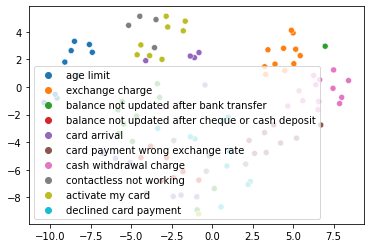

In [ ]:
sns.scatterplot(lm_emb[:,0], lm_emb[:,1], hue = emb_lab,)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel("Embedding Dim 1")
plt.ylabel("Embedding Dim 2")
plt.title("SBERT Query Embeddings - Training")

In [ ]:
sns.scatterplot(snn_emb[:,0], snn_emb[:,1], hue = emb_lab)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel("Embedding Dim 1")
plt.ylabel("Embedding Dim 2")
plt.title("PSNN Query Embeddings - Training")

In [ ]:
emb_sample_ix = [i for i in range(len(test_labels)) if test_labels[i] in a]
emb_sample_ix = np.random.choice(emb_sample_ix, size = 100, replace = False)

SBERT_embedding = np.zeros((len(emb_sample_ix), 768))
SNN_embedding = np.zeros((len(emb_sample_ix), PseudoSiamese.output_size))
emb_lab = []

for i in range(len(emb_sample_ix)):
  ix = emb_sample_ix[i]
  query = test_queries[ix]
  label = test_labels[ix]
  emb_lab.append(label)

  # embed with SBERT 
  encoded_query = tokenizer(query, padding=True, truncation=True,return_token_type_ids=False, max_length=128, return_tensors='pt')
  encoded_query.to(device)
  lm_enc = lm(**encoded_query) # ONLY use the language model
  query_embeddings_LM = mean_pooling(lm_enc, encoded_query['attention_mask']) 
  SBERT_embedding[i,:] = query_embeddings_LM.detach().cpu().numpy()

  # embed with PSNN
  query_embeddings_SNN = PseudoSiamese.forward_one(encoded_query)
  SNN_embedding[i,:] = query_embeddings_SNN.detach().cpu().numpy()


emb_lab = [label_map[x] for x in emb_lab]
lm_emb = TSNE(n_components=2).fit_transform(SBERT_embedding)
snn_emb = TSNE(n_components=2).fit_transform(SNN_embedding)

In [ ]:
sns.scatterplot(lm_emb[:,0], lm_emb[:,1], hue = emb_lab,)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel("Embedding Dim 1")
plt.ylabel("Embedding Dim 2")
plt.title("SBERT Query Embeddings - Testing")

In [ ]:
sns.scatterplot(snn_emb[:,0], snn_emb[:,1], hue = emb_lab)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel("Embedding Dim 1")
plt.ylabel("Embedding Dim 2")
plt.title("PSNN Query Embeddings - Testing")

# Stack ZSL on top of another model

As it turns out, this doesn't help SNN, but it does help the centroid method 

In [ ]:
# from functools import reduce
top_k = 3 # the number of items to gather from each model 
n_correct_ZSL_stackSNN = 0
n_correct_ZSL_stackCENT = 0
n_correct_ZSL_stackUNION = 0
for ix in range(len(test_queries)):
  query = test_queries[ix]
  label = label_map[test_labels[ix]]

  encoded_query = tokenizer(query, padding=True, truncation=True,return_token_type_ids=False, max_length=128, return_tensors='pt')
  encoded_query.to(device)
  query_embeddings_SNN = PseudoSiamese.forward_one(encoded_query)
  top_intents = torch.topk(torch.norm(query_embeddings_SNN-intents_embeddings, 2, dim = 1), k = top_k, largest = False).indices.squeeze()
  if top_k == 1:
    top_intents = [top_intents]
  top_intents_SNN = []
  for i in range(len(top_intents)):
    label_ix = intent_set[top_intents[i].item()]
    top_intents_SNN.append(label_map[label_ix])

  lm_enc = lm(**encoded_query) # ONLY use the language model
  query_embeddings_LM = mean_pooling(lm_enc, encoded_query['attention_mask']) 

  top_intents = torch.topk(torch.inner(query_embeddings_LM, intents_embeddings_raw), k = top_k).indices.squeeze()
  if top_k == 1:
    top_intents = [top_intents]
  top_intents_SBERT = []
  for i in range(len(top_intents)):
    label_ix = intent_set[top_intents[i].item()]
    top_intents_SBERT.append(label_map[label_ix])

  top_intents_CENTROID = []
  top_intents = torch.topk(torch.inner(query_embeddings_LM, intent_centroids_lm), k = top_k).indices.squeeze()
  if top_k == 1:
    top_intents = [top_intents]
  for i in range(len(top_intents)):
    label_ix = intent_set[top_intents[i].item()]
    top_intents_CENTROID.append(label_map[label_ix])

  # # # use one of the above models as the suggestion engine for ZSL
  pred_ZSL = classifier(query, top_intents_CENTROID)
  if pred_ZSL['labels'][0] == label:
    n_correct_ZSL_stackCENT +=1 

      # # use one of the above models as the suggestion engine for ZSL
  pred_ZSL = classifier(query, top_intents_SNN)
  if pred_ZSL['labels'][0] == label:
    n_correct_ZSL_stackSNN +=1 

  # # # use one of the above models as the suggestion engine for ZSL
  pred_ZSL = classifier(query, list(set(top_intents_SNN).union(set(top_intents_CENTROID))))
  if pred_ZSL['labels'][0] == label:
    n_correct_ZSL_stackUNION +=1 

In [ ]:
print("Centroid ", n_correct_ZSL_stackCENT)
print("SNN ", n_correct_ZSL_stackSNN)
print("Union ", n_correct_ZSL_stackUNION)

Centroid  654
SNN  712
Union  676


Close out the project with one more task 
- Ensemble: find some smart way of using the confidence scores from the NN/SBERT/SNN models and then combining them
- RL: 

In [ ]:
# Do manual remapping
label_map_ZSL = label_map.copy()
label_map_ZSL[0] = 'activate card'
label_map_ZSL[17] = 'wrong or incorrect exchange rate'
label_map_ZSL[19] = 'withdrawal charge'
label_map_ZSL[34] = 'extra charge'

In [ ]:
# hypotheses_set = [top_intents_SNN, top_intents_SBERT, top_intents_CENTROID]
# list(reduce(set.intersection, [set(item) for item in hypotheses_set]))

# Enesemble method

In [ ]:
from sklearn.preprocessing import quantile_transform

# Score in a loop
n_models = 3 
pred_train = np.zeros((len(train_queries), n_models*len(intent_set)))

for ix in range(len(train_queries)):
  query = train_queries[ix]

  # LM + SNN's FF layer 
  encoded_query = tokenizer(query, padding=True, truncation=True,return_token_type_ids=False, max_length=128, return_tensors='pt')
  encoded_query.to(device)
  query_embeddings_SNN = PseudoSiamese.forward_one(encoded_query)
  preds_SNN = F.softmax(1/torch.norm(query_embeddings_SNN-intents_embeddings, 2, dim = 1), dim=-1).squeeze().detach().cpu().numpy().reshape(-1,1)  # take softmax over inverse distance (closer is better)

  lm_enc = lm(**encoded_query) # ONLY use the language model
  query_embeddings_LM = mean_pooling(lm_enc, encoded_query['attention_mask']) 

  preds_SBERT = F.softmax(torch.inner(query_embeddings_LM, intents_embeddings_raw), dim=-1).squeeze().detach().cpu().numpy().reshape(-1,1)

  preds_CENTROID = F.softmax(torch.inner(query_embeddings_LM, intent_centroids_lm), dim=-1).squeeze().detach().cpu().numpy().reshape(-1,1)

  pred_train[ix,:] = np.concatenate([quantile_transform(preds_SNN, n_quantiles = len(intent_set), copy = True), 
                                  quantile_transform(preds_SBERT, n_quantiles = len(intent_set), copy = True),
                                  quantile_transform(preds_CENTROID, n_quantiles = len(intent_set), copy = True)], axis = 0).squeeze()

  

In [ ]:
X_train = pred_train
y_train = train_labels

print(X_train.shape)

(600, 90)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestClassifier(random_state = 6864)

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 500, num = 10)]
# Degree of regularization on each tree
ccp_alpha = [x for x in np.logspace(start = -8, stop = 1, num = 10)]
ccp_alpha.append(0)
# Number of features to consider at every split, including all features 
max_features = ['auto', 0.5, 0.7, 0.8, 0.9, None]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 100, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 3, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 5]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'ccp_alpha':ccp_alpha,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 300, cv = 5, verbose=2, random_state=6864, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

rf_random.best_estimator_

ens_clf = rf_random.best_estimator_

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 19.5min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 27.4min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 28.4min finished


In [ ]:
# Score in a loop
n_models = 3 
pred_test = np.zeros((len(test_queries), n_models*len(intent_set)))

for ix in range(len(test_queries)):
  query = test_queries[ix]

  # LM + SNN's FF layer 
  encoded_query = tokenizer(query, padding=True, truncation=True,return_token_type_ids=False, max_length=128, return_tensors='pt')
  encoded_query.to(device)
  query_embeddings_SNN = PseudoSiamese.forward_one(encoded_query)
  preds_SNN = F.softmax(1/torch.norm(query_embeddings_SNN-intents_embeddings, 2, dim = 1), dim=-1).squeeze().detach().cpu().numpy().reshape(-1,1)  # take softmax over inverse distance (closer is better)
  # they're too close together sometimes, so do a quantile transform
  lm_enc = lm(**encoded_query) # ONLY use the language model
  query_embeddings_LM = mean_pooling(lm_enc, encoded_query['attention_mask']) 

  preds_SBERT = F.softmax(torch.inner(query_embeddings_LM, intents_embeddings_raw), dim=-1).squeeze().detach().cpu().numpy().reshape(-1,1)

  preds_CENTROID = F.softmax(torch.inner(query_embeddings_LM, intent_centroids_lm), dim=-1).squeeze().detach().cpu().numpy().reshape(-1,1)

  pred_test[ix,:] = np.concatenate([quantile_transform(preds_SNN, n_quantiles = len(intent_set), copy = True), 
                                    quantile_transform(preds_SBERT, n_quantiles = len(intent_set), copy = True),
                                    quantile_transform(preds_CENTROID, n_quantiles = len(intent_set), copy = True)], axis = 0).squeeze()

X_test = pred_test
y_test = test_labels

In [ ]:
pred_test_ens = ens_clf.predict(X_test)
pred_test_ens_p = ens_clf.predict_proba(X_test)

np.sum(pred_test_ens==y_test)/len(y_test)

0.829

In [ ]:
# Now lets use the ensemble to create an augmented dataset with pseudolabels 

# Score in a loop
n_models = 3 
pred_test = np.zeros((len(holdout_queries), n_models*len(intent_set)))

for ix in range(len(holdout_queries)):
  query = holdout_queries[ix]

  # LM + SNN's FF layer 
  encoded_query = tokenizer(query, padding=True, truncation=True,return_token_type_ids=False, max_length=128, return_tensors='pt')
  encoded_query.to(device)
  query_embeddings_SNN = PseudoSiamese.forward_one(encoded_query)
  preds_SNN = F.softmax(1/torch.norm(query_embeddings_SNN-intents_embeddings, 2, dim = 1), dim=-1).squeeze().detach().cpu().numpy().reshape(-1,1)  # take softmax over inverse distance (closer is better)
  # they're too close together sometimes, so do a quantile transform
  lm_enc = lm(**encoded_query) # ONLY use the language model
  query_embeddings_LM = mean_pooling(lm_enc, encoded_query['attention_mask']) 

  preds_SBERT = F.softmax(torch.inner(query_embeddings_LM, intents_embeddings_raw), dim=-1).squeeze().detach().cpu().numpy().reshape(-1,1)

  preds_CENTROID = F.softmax(torch.inner(query_embeddings_LM, intent_centroids_lm), dim=-1).squeeze().detach().cpu().numpy().reshape(-1,1)

  pred_test[ix,:] = np.concatenate([quantile_transform(preds_SNN, n_quantiles = len(intent_set), copy = True), 
                                    quantile_transform(preds_SBERT, n_quantiles = len(intent_set), copy = True),
                                    quantile_transform(preds_CENTROID, n_quantiles = len(intent_set), copy = True)], axis = 0).squeeze()

X_test = pred_test
y_test = holdout_labels

In [ ]:
pred_test_ens = ens_clf.predict(X_test)
pred_test_ens_p = ens_clf.predict_proba(X_test)

np.sum(pred_test_ens==y_test)/len(y_test)

0.8221979820016362

In [ ]:
# look at ensemble output and grab the queries that we're most confident in across each label
probs = np.argmax(pred_test_ens_p, axis=1)
pseudo_probs = [pred_test_ens_p[i,probs[i]] for i in range(len(probs))]
pseudo_labels = pred_test_ens 
pseudo_df = pd.DataFrame({'query': holdout_queries, 'label':y_test ,'pseudolabel': pseudo_labels, 'prob': pseudo_probs})
pseudo_df["rank"] = pseudo_df.groupby("pseudolabel")["prob"].rank("dense", ascending=False)

In [ ]:
pseudo_df.to_csv('Pseudo_trainingdata{}.csv'.format(n_samples), index = False)